In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import random
import os
import bz2
from src.QuoteBankData import QuoteBankData
from src.Deaths import Deaths
import src.utilities.quotebank_preprocessing_utils as utils
from src.CONSTS import DATA_PATH, COLORS, KEYWORDS_JSON_FILE_PATH, KEYWORDS_FILE_PATH, BEGIN_YEAR, END_YEAR, RENAME_CAUSE_COLS, DROP_CAUSE_COLS, COLOR_MAP, GENERATED_IMAGES_PATH
from tqdm import tqdm
from src.utilities.synonym_utils import add_new_synonyms
from src.utilities.add_features import expand_line
from src.utilities.utils import *
import pandas as pd
import pygal
from pygal.style import Style
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2


In [2]:
import warnings
import collections

warnings.filterwarnings("ignore")

def save_meta_data_quotes():
    quotebank.quotes_occurrences_df = pd.DataFrame()
    for year in range(BEGIN_YEAR, END_YEAR + 1):
        print(year)
        if year == 2017: break
        dict_df_row = {"Year": year}
        for key in quotebank.keywords:
            file = key.output_filenames[year-BEGIN_YEAR]
            with open(file, 'rU') as f:
                quotes = pd.read_json(file, lines=True)
            if len(quotes) > 0:
                # Save total number of quotes per year per topic in df
                num_of_quotes = quotes["n_appearances"].sum()

                for _, line_quotes in quotes.iterrows():
                    # Safe number of quotes per topic per year per country of url
                    country_urls = line_quotes['country_urls']
                    for country in country_urls:
                        if country == "Great Britain":
                            country = "United Kingdom"
                        if (country, year) in key.country_url_occurences:
                            key.country_url_occurences[(country, year)] += 1
                        else:
                            key.country_url_occurences[(country, year)] = 1

                    # Safe number of quotes per topic per year per country of speaker
                    country_speaker = line_quotes['country_speaker']
                    if country_speaker:
                        if isinstance(country_speaker, list):        # if multiple countries, take most occuring
                            country_speaker = collections.Counter(country_speaker).most_common(1)[0][0]

                        if (country_speaker,year) in key.country_speaker_occurences:
                            key.country_speaker_occurences[(country_speaker,year)] +=1
                        else:
                            key.country_speaker_occurences[(country_speaker,year)] = 1 
            else:
                num_of_quotes = 0
            dict_df_row[key.name] = num_of_quotes
            
        quotebank.quotes_occurrences_df = quotebank.quotes_occurrences_df.append(dict_df_row, ignore_index = True)
        cols = quotebank.quotes_occurrences_df.columns
        quotebank.quotes_occurrences_df[cols] = quotebank.quotes_occurrences_df[cols].astype(int)

In [3]:
def get_country_per_year_count(url_or_speaker, countries, percentage = False):
    # Check value
    if url_or_speaker != "url" and url_or_speaker != "speaker":
        raise ValueError("Did not choose url or speaker")
    
    # Initialize output
    topic_appearance_country = np.zeros((len(quotebank.keywords), len(countries)+1))
    topics = list()
    for i in range(len(quotebank.keywords)):
        topics.append(quotebank.keywords[i].name)
        if url_or_speaker == "url":
            for key in quotebank.keywords[i].country_url_occurences:
                if key[0] in english_countries:
                    topic_appearance_country[i, countries.index(key[0])] = quotebank.keywords[i].country_url_occurences[key]
                elif key[0] is not None:
                    topic_appearance_country[i, -1] += quotebank.keywords[i].country_url_occurences[key]
                    
        elif url_or_speaker == "speaker":
            for key in quotebank.keywords[i].country_speaker_occurences:
                if key[0] in english_countries:
                    topic_appearance_country[i, countries.index(key[0])] = quotebank.keywords[i].country_speaker_occurences[key]
                elif key[0] is not None:
                    topic_appearance_country[i, -1] += quotebank.keywords[i].country_speaker_occurences[key]
                
    if percentage:
        topic_appearance_country = np.transpose(topic_appearance_country/np.sum(topic_appearance_country, axis = 0))*100
    else:
        topic_appearance_country = np.transpose(topic_appearance_country)
    topic_appearance_country = pd.DataFrame(data = topic_appearance_country,
                                           columns = topics)
    
    return topic_appearance_country

In [4]:
def get_country_a2_code(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown'  
    return cn_a2_code

In [5]:
def reduce_df(df_original, percentage_treshold):
    df = df_original.copy()
    df_percentage = df.copy()
    # Check if rows are percentages
    if int(df_percentage.iloc[0].sum()) != 100:
        for index, row in df_percentage.iterrows():
            df_percentage.iloc[index] = (row/row.sum()) * 100
        
    other = np.zeros(len(df))
    for column in df:
        if df_percentage[column].max() < percentage_treshold:
            other += df[column].values
            df.drop([column], axis=1, inplace=True)
    
    df = df.assign(Other=other)
    return df

In [6]:
def stacked_barplot(df, x_labels=None, y_label=None, title=None, width = 0.35):
    ax = plt.gca()
    columns = df.columns
    #fig, ax = plt.subplots()
    df_plot = df

    df_plot.plot.bar(colormap = COLOR_MAP, ax=ax, stacked = True)

    plt.ylabel(y_label)
    handles, lables_legend = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], lables_legend[::-1], loc='center left', bbox_to_anchor=(1, 0.5))
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xticklabels(labels, rotation=45, ha='right')




In [7]:
def get_quote_occurences_per_country_year(url_or_speaker):
    """This function returns the number of quotes from a country per year, based on speaker or url.
    param: url_or_speaker: str
    return: totals_per_country: dict, keys are like (country,year)"""
    
    # Check value
    if url_or_speaker != "url" and url_or_speaker != "speaker":
        raise ValueError("Did not choose url or speaker")
    
    # Safe variable
    totals_per_country = dict()
    # Get occurences form url from countries
    if url_or_speaker == "url":
        for i in range(len(quotebank.keywords)):   
            for key in quotebank.keywords[i].country_url_occurences:
                if key in totals_per_country:
                    totals_per_country[key] += quotebank.keywords[i].country_url_occurences[key]
                else:
                    totals_per_country[key] = quotebank.keywords[i].country_url_occurences[key]
    # Get occurences of speakers from countries              
    elif url_or_speaker == "speaker":
        for i in range(len(quotebank.keywords)):   
            for key in quotebank.keywords[i].country_speaker_occurences:
                if key in totals_per_country:
                    totals_per_country[key] += quotebank.keywords[i].country_speaker_occurences[key]
                else:
                    totals_per_country[key] = quotebank.keywords[i].country_speaker_occurences[key]
    
    return totals_per_country


In [8]:
def map_countries_according_to_mag_order(totals_per_country, year):
    """Creates a mapping dict for the occurences of quotes according to order of magintude.
    Out put is a list of dicts, with first dict for countries for which between 10^0 and 
    10^1 quotes were found, etc.
    param: totals_per_country: dict
            year: int
            
    return: mapping: list of dicts"""
    
    c_code = list()
    countries = totals_per_country.keys()
    quotes = list()
    for country_year in countries:
        if country_year[1] == year:
            quotes.append(totals_per_country[country_year])
            cn_a2_code = get_country_a2_code(country_year[0])
            c_code.append(cn_a2_code)
    
    all_countries_code = ['af', 'ax', 'al', 'dz', 'as', 'ad', 'ao', 'ai', 'aq', 'ag', 'ar', 'am', 'aw', 'au', 'at', 'az',
                        'bs', 'bh', 'bd', 'bb', 'by', 'be', 'bz', 'bj', 'bm', 'bt', 'bo', 'bq', 'ba', 'bw', 'bv', 'br', 'io',
                        'bn', 'bg', 'bf', 'bi', 'kh', 'cm', 'ca', 'cv', 'ky', 'cf', 'td', 'cl', 'cn', 'cx', 'cc', 'co', 'km',
                        'cg', 'cd', 'ck', 'cr', 'ci', 'hr', 'cu', 'cw', 'cy', 'cz', 'dk', 'dj', 'dm', 'do', 'ec', 'eg', 'sv', 'gq',
                        'er', 'ee', 'et', 'fk', 'fo', 'fj', 'fi', 'fr', 'gf', 'pf', 'tf', 'ga', 'gm', 'ge', 'de', 'gh', 'gi',
                        'gr', 'gl', 'gd', 'gp', 'gu', 'gt', 'gg', 'gn', 'gw', 'gy', 'ht', 'hm', 'va', 'hn', 'hk', 'hu', 'is',
                        'in', 'id', 'ir', 'iq', 'ie', 'im', 'il', 'it', 'jm', 'jp', 'je', 'jo', 'kz', 'ke', 'ki', 'kp', 'kr',
                        'kw', 'kg', 'la', 'lv', 'lb', 'ls', 'lr', 'ly', 'li', 'lt', 'lu', 'mo', 'mk', 'mg', 'mw', 'my', 'mv',
                        'ml', 'mt', 'mh', 'mq', 'mr', 'mu', 'yt', 'mx', 'fm', 'md', 'mc', 'mn', 'me', 'ms', 'ma', 'mz', 'mm',
                        'na', 'nr', 'np', 'nl', 'nc', 'nz', 'ni', 'ne', 'ng', 'nu', 'nf', 'mp', 'no', 'om', 'pk', 'pw', 'ps',
                        'pa', 'pg', 'py', 'pe', 'ph', 'pn', 'pl', 'pt', 'pr', 'qa', 're', 'ro', 'ru', 'rw', 'bl', 'sh', 'kn',
                        'lc', 'mf', 'pm', 'vc', 'ws', 'sm', 'st', 'sa', 'sn', 'rs', 'sc', 'sl', 'sg', 'sx', 'sk', 'si', 'sb',
                        'so', 'za', 'gs', 'ss', 'es', 'lk', 'sd', 'sr', 'sj', 'sz', 'se', 'ch', 'sy', 'tw', 'tj', 'tz', 'th',
                        'tl', 'tg', 'tk', 'to', 'tt', 'tn', 'tr', 'tm', 'tc', 'tv', 'ug', 'ua', 'ae', 'gb', 'us', 'um', 'uy',
                        'uz', 'vu', 've', 'vn', 'vg', 'vi', 'wf', 'eh', 'ye', 'zm', 'zw']
    
    mapping = [dict() for i in range(7)]
    for i, code in enumerate(c_code):
        s_code = code.lower()
        if s_code in all_countries_code:
            all_countries_code.remove(s_code)
        if s_code != 'unknown':
            quote_order = np.log(quotes[i])/np.log(10)
            if quote_order < 1:
                mapping[1][s_code] = 1
            elif quote_order < 2:
                mapping[2][s_code] = 1
            elif quote_order < 3:
                mapping[3][s_code] = 1
            elif quote_order < 4:
                mapping[4][s_code] = 1
            elif quote_order < 5:
                mapping[5][s_code] = 1
            elif quote_order < 6:
                mapping[6][s_code] = 1
    # No data countries
    for country in all_countries_code:
        mapping[0][country] = 1

    return mapping

In [9]:
def create_world_map(mapping, safe_name):
    custom_style = Style(colors=('#D3D3D3','#4FFFFF','#00C9E4','#0094C2','#006198','#003269','#000036'))

    # create a world map
    worldmap =  pygal.maps.world.World(style=custom_style)

    # set the title of the map
    #worldmap.title = 'Countries of quotes'
    
    # adding the countries
    worldmap.add("No Data", mapping[0])
    for i in range(1,len(mapping)):
        if mapping[i].keys():
            worldmap.add(str("{:0.0f}-{:0.0f}".format(i,i+1)), mapping[i])

    worldmap.render_to_file(GENERATED_IMAGES_PATH + safe_name + '.svg')


# First Get info on quote occurence in countries

In [10]:
quotebank = QuoteBankData("Asymmetry of News", [])
quotebank.read_keywords_from_file()
utils.create_directories_for_every_year()
quotebank.create_json_dumps_filenames_for_each_keyword()

In [11]:
save_meta_data_quotes()

2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [12]:
# Create Maps for all years for speaker and url
url_speaker = ["url","speaker"]
for target in url_speaker:
    for year in range(2008,2017):
        totals_per_country = get_quote_occurences_per_country_year(target)
        mapping = map_countries_according_to_mag_order(totals_per_country, year)
        create_world_map(mapping, str(year) + "_" + target + "_country_occurences")

# Get country spefic distributions of quote topics


In [141]:
english_countries = ['United Kingdom', 'United States of America','Canada', 'Australia', 'India']
df_speaker = get_country_per_year_count("speaker", english_countries, percentage = True)
df_speaker = reduce_df(df_speaker, 5)
df_url = get_country_per_year_count("url", english_countries, percentage = True)
df_url = reduce_df(df_url, 5)


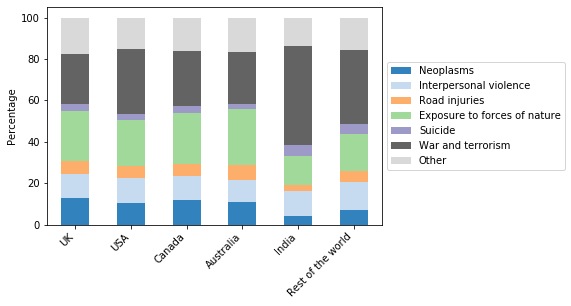

In [142]:
labels = english_countries
labels[1] = "USA"
labels[0] = "UK"
labels.append("Rest of the world")
stacked_barplot(df_speaker, labels, "Percentage")

In [ ]:
labels = english_countries
labels[1] = "USA"
labels[0] = "UK"
labels.append("Other countries")
stacked_barplot(df_url, labels, "Percentage")

nan


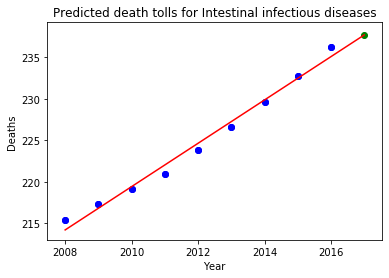

nan


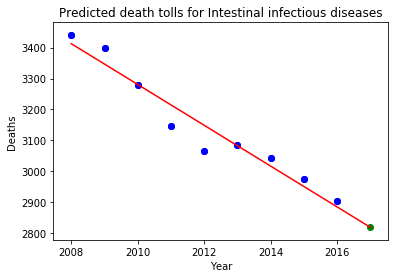

nan


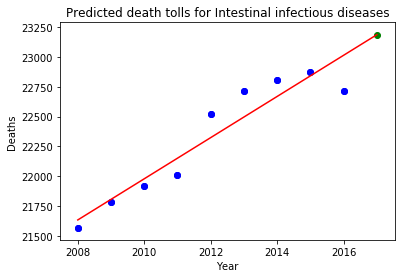

nan


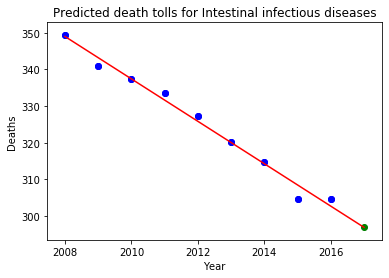

nan


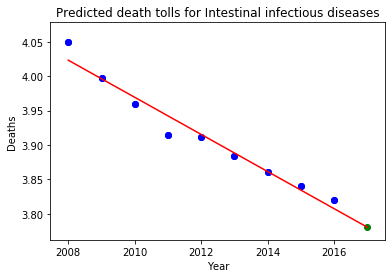

nan


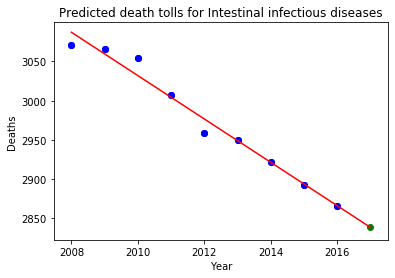

nan


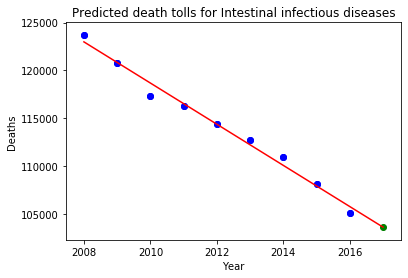

nan


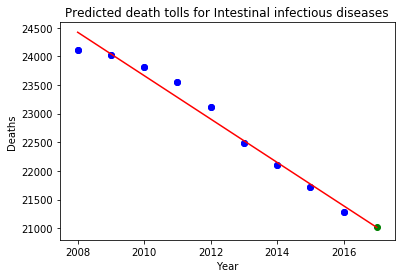

nan


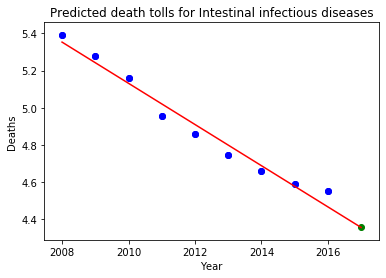

nan


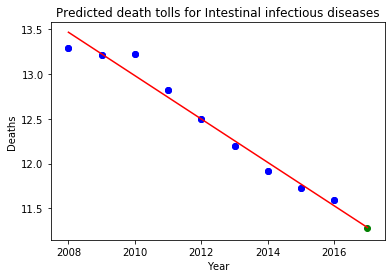

nan


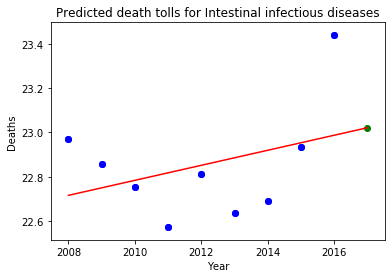

nan


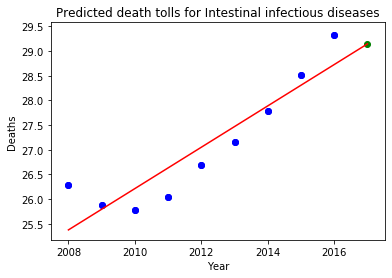

nan


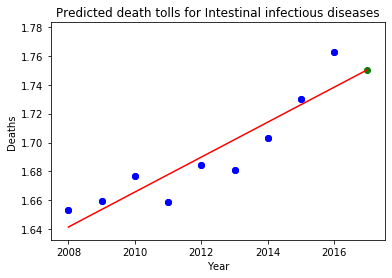

In [132]:
death_by_cause_path=  "data/annual_number_of_deaths_by_cause.csv"
regions = ['Latin America and Caribbean','North Africa and Middle East','Sub-Saharan Africa','Oceania','Central Asia', 'East Asia','South Asia', 'Southeast Asia','Central Europe',"Eastern Europe", 'Western Europe',  'United States','Canada']
main_regions = {'Latin America': ['Latin America and Caribbean'],
                'North America': ['United States','Canada'],
                'Europe': ['Central Europe',"Eastern Europe", 'Western Europe'],
                'Sub-Saharan Africa': ['Sub-Saharan Africa'],
                'North Africa and Middle East': ['North Africa and Middle East'],
                'Asia':['Central Asia', 'East Asia','South Asia', 'Southeast Asia'],
                'Oceania': ['Oceania']}

deaths = dict()
for region in regions:
    df = Deaths("deaths_by_cause", region, death_by_cause_path, rename_cols = RENAME_CAUSE_COLS, drop_cols = DROP_CAUSE_COLS).df
    for main_region in main_regions:
        if region in main_regions[main_region]:
            if main_region in deaths:
                deaths[main_region] += df.fillna(0)
                deaths[main_region]["Year"] = deaths[main_region]["Year"]/2
            else:
                deaths[main_region] = df.fillna(0)


In [133]:
topics = ['Meningitis', 'Lower respiratory infections',
       'Intestinal infectious diseases', 'Cardiovascular diseases',
       'Alzheimer disease and other dementias', 'Chronic kidney disease',
       'Chronic respiratory diseases',
       'Cirrhosis and other chronic liver diseases', 'Digestive diseases',
       'Hepatitis', 'Neoplasms', 'Parkinson disease',
       'Fire, heat, and hot substances', 'Malaria', 'Drowning',
       'Interpersonal violence', 'Hiv/aids', 'Tuberculosis', 'Road injuries',
       'Maternal disorders', 'Neonatal disorders', 'Diarrheal diseases',
       'Suicide', 'Diabetes mellitus', 'Poisonings', 'War and terrorism',
       'Exposure to forces of nature', 'Nutritional deficiencies',
       'Drug use and alcoholism']
deaths_2009 = pd.DataFrame()
for death in deaths:
    deaths_2009 = deaths_2009.append(deaths[death][topics][deaths[death]["Year"] == 2009])
    
deaths_2009 = deaths_2009.reset_index()
deaths_2009_percentage = deaths_2009.copy()
for i in range(len(deaths_2009)):
    #deaths_2009.iloc[-1] = deaths_2009.iloc[-1] - deaths_2009.iloc[i]
    deaths_2009_percentage.loc[i] = deaths_2009_percentage.loc[i]/deaths_2009_percentage.loc[i].sum()*100


In [135]:
deaths_2009_reduce = reduce_df(deaths_2009, 5)
deaths_2009_percentage_reduce = reduce_df(deaths_2009_percentage, 5)
deaths_2009_percentage_reduce

,Lower respiratory infections,Cardiovascular diseases,Alzheimer disease and other dementias,Chronic respiratory diseases,Digestive diseases,Neoplasms,Malaria,Interpersonal violence,Hiv/aids,Tuberculosis,Road injuries,Neonatal disorders,Diarrheal diseases,Other
0,5.571680,26.981763,4.604015,4.895227,6.151717,16.994135,0.009322,5.266372,1.684401,0.674232,4.027300,3.312911,1.053822,18.773103
1,5.099568,39.885329,3.237052,4.063825,3.863075,12.573244,0.135270,0.619877,0.323523,0.777713,5.716943,7.957746,2.188482,13.558355
2,9.628051,9.731393,0.923374,1.817296,3.259543,5.286132,9.355903,0.847014,18.088901,5.528527,1.986838,9.517930,8.774945,15.254156
3,7.166471,28.801627,0.840523,12.821727,2.490904,7.604930,0.817713,1.107069,2.945925,1.711307,3.254400,5.528774,4.382900,20.525731
4,4.860653,31.799092,2.627007,10.371273,4.232281,14.942277,0.360468,0.452806,0.973228,3.428317,3.012466,4.883192,4.400036,13.656905
5,2.556206,45.749532,6.554270,3.879898,4.664990,23.260509,0.000218,0.560317,0.327625,0.413507,1.164198,0.277658,0.149387,10.441685
6,3.363217,33.721305,8.721510,6.926332,4.113099,26.147116,0.000000,0.735156,0.407577,0.037864,1.762369,0.541165,0.412048,13.111243


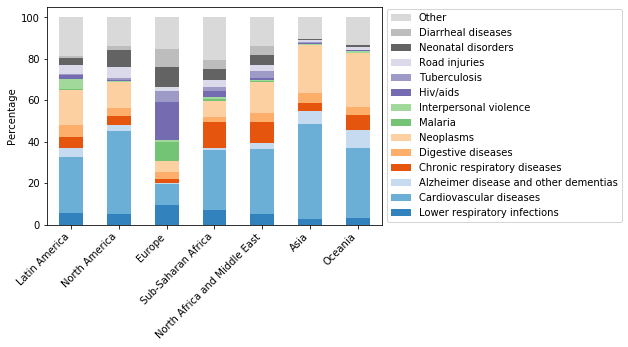

In [148]:
labels = main_regions.keys()
stacked_barplot(deaths_2009_percentage_reduce, labels, "Percentage")

In [58]:
plt.get_cmap('tab20c')

AttributeError: 'ListedColormap' object has no attribute 'colours'